![](../../images/featuretools.png)

# Predicting Retail Spending with Automated Feature Engineering in Featuretools

In this notebook, we will implement an automated feature engineering solution in [Featuretools](https://docs.featuretools.com/#minute-quick-start) for a set of online retail purchases. The dataset (available from the [UCI machine learning repository](https://archive.ics.uci.edu/ml/datasets/online+retail#)), a series of time-stamped purchases, does not come with any labels, so we'll have to make our own prediction problem. After defining the problem, we can use automated feature engineering to build a set of features that we then feed to a machine learning model for training. 

This set of data is great practice both for defining our own prediction problem, and for using some of the time-based capabilities of Featuretools such as cutoff times. Whenever we have time-series data, we need to be extra careful to not "leak labels" or use information from the future to predict a past event. Usually, when we're doing manual feature engineering, this can be quite an issue and often, a system will work well in development but utterly fail when deployed because it was trained on illegitimate data. Fortunately, Featuretools will take care of the time issue for us, creating a rich set of features that follow any time limitations. 

## Roadmap 

Following is an outline for this notebook:

1. Read in data, inspect, and clean
2. Develop a prediction problem
    * Create a dataframe of labels - what we want to predict, and cutoff times - the point that all data must come before for predicting a label
3. Create an entityset and add entities
    * Normalize the original table to develop new tables 
    * These new tables can be used for making features
4. Run deep feature sythesis on the entityset to make features
    * Use the cutoff times to make features using valid data for each label
5. Use the features to train a machine learning model
    * Measure performance of the model relative to an informed baseline
6. Tune deep feature synthesis 
    * Specify custom primitives
    * Adjust maximum depth of features


This problem is a great display of both the time and feature-creation capabilities of Featuretools. Doing this problem by hand and ensuring we use only valid data for each label is a daunting task! 

In [1]:
# Data manipulation
import pandas as pd 
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Automated feature engineering
import featuretools as ft

# Machine learning
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer, MinMaxScaler
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, roc_curve
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier

### Load in Raw Data

The raw data is a collection of purchases from an online retailer collected in 2011. Each row in the original data represents one product that was purchased with multiple purchases forming an order. There are a few issues with the data that will need to be addressed (as with most real-world datasets)!

This code loads in the data from an s3 bucket, converts the price in Pounds to dollars (based on the exchange rate on May 31, 2011), and creates a column representing the total of the purchase. The original data description can be found on [the UCI Machine Learning Repository.](https://archive.ics.uci.edu/ml/datasets/online+retail#)

In [2]:
csv_s3 = "s3://featurelabs-static/online-retail-logs.csv"
data = pd.read_csv(csv_s3, parse_dates=["order_date"])

# Convert to dollars
data['price'] = data['price'] * 1.65
data['total'] = data['price'] * data['quantity']

# Restrict data to 2011
data = data[data['order_date'].dt.year == 2011]

data.head()

,order_id,product_id,description,quantity,order_date,price,customer_id,country,total
42481,539993,22386,JUMBO BAG PINK POLKADOT,10,2011-01-04 10:00:00,3.2175,13313.0,United Kingdom,32.175
42482,539993,21499,BLUE POLKADOT WRAP,25,2011-01-04 10:00:00,0.6930,13313.0,United Kingdom,17.325
42483,539993,21498,RED RETROSPOT WRAP,25,2011-01-04 10:00:00,0.6930,13313.0,United Kingdom,17.325
42484,539993,22379,RECYCLING BAG RETROSPOT,5,2011-01-04 10:00:00,3.4650,13313.0,United Kingdom,17.325
42485,539993,20718,RED RETROSPOT SHOPPER BAG,10,2011-01-04 10:00:00,2.0625,13313.0,United Kingdom,20.625


## Data Cleaning

There are a few issues we need to address with the data. First, we'll drop the duplicated rows, then we'll drop any rows that contain a `nan`. Finally, we can add a `Boolean` column indicating whether or not an order is a cancellation.

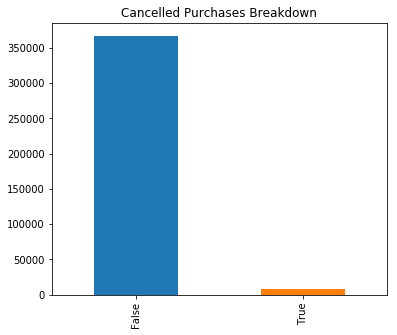

In [3]:
# drop the duplicates
data = data.drop_duplicates()

# drop rows with null customer id
data = data.dropna(axis=0)

data['cancelled'] = data['order_id'].str.startswith('C')
data['cancelled'].value_counts().plot.bar(figsize = (6, 5));
plt.title('Cancelled Purchases Breakdown');

All of the cancelled orders have negative quantities which mean that they cancel out with the corresponding purchase. We'll leave in the cancelled purchases, because if our goal (defined later in the prediction problem) is to predict the total amount purchased by a customer, we'll need to take into account their cancelled orders.

In [4]:
data.describe()

,quantity,price,customer_id,total
count,375250.000000,375250.000000,375250.000000,375250.000000
mean,12.252296,5.762031,15265.136168,33.972397
std,258.180877,119.054102,1710.927381,733.803756
min,-80995.000000,0.000000,12346.000000,-277974.840000
25%,2.000000,2.062500,13901.000000,7.012500
50%,5.000000,3.217500,15108.000000,19.305000
75%,12.000000,6.187500,16767.000000,32.670000
max,80995.000000,64300.500000,18287.000000,277974.840000


We can see that most total purchase prices are less than \$50. We can plot the purchase total by country (limited to only positive amounts and less than \$1000) to see if there are differences between countries.

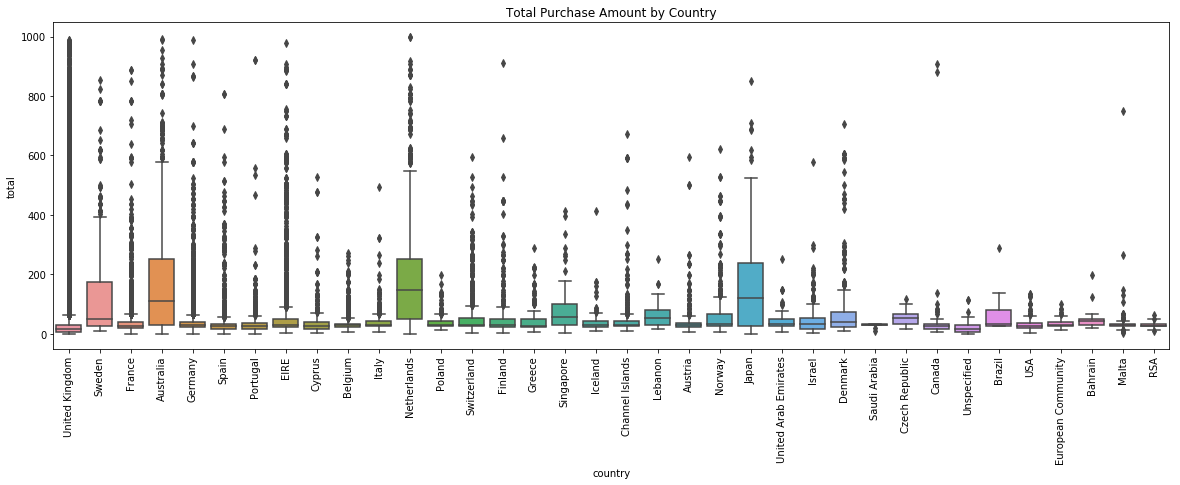

In [5]:
plt.figure(figsize = (20, 6))
sns.boxplot(x = 'country', y = 'total', data = data[(data['total'] > 0) & (data['total'] < 1000)]);
plt.title("Total Purchase Amount by Country");
plt.xticks(rotation = 90);

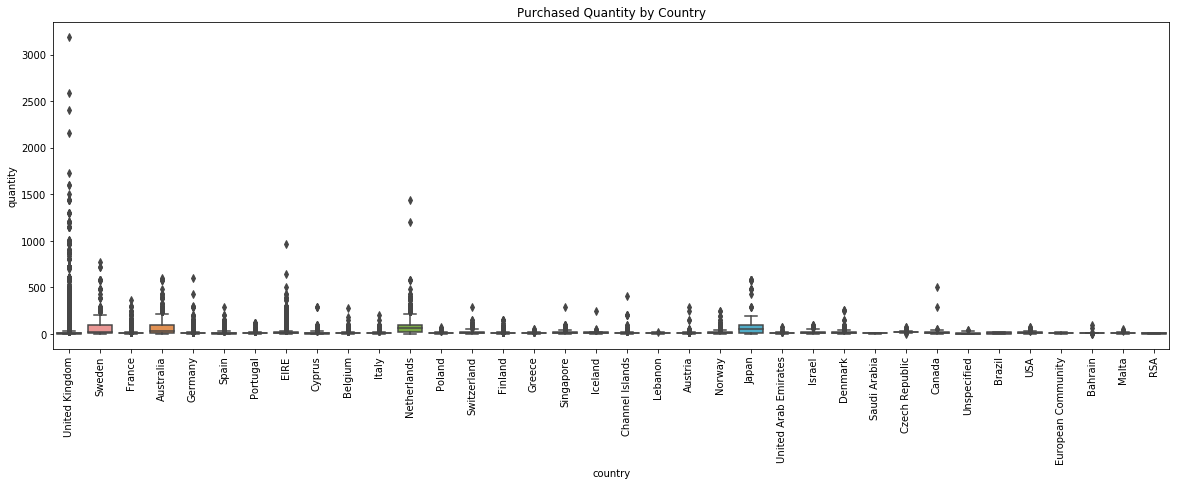

In [6]:
plt.figure(figsize = (20, 6))
sns.boxplot(x = 'country', y = 'quantity', data = data[(data['total'] > 0) & (data['total'] < 1000)]);
plt.title("Purchased Quantity by Country");
plt.xticks(rotation = 90);

Both the purchase total and the quantity are heavily skewed. This occurs often in real-world data and means this might be difficult as a regression problem (predict the actual spending amount). We might want to frame the problem as classification because the large purchase totals could throw off a machine learning algorithm. Our other option would be to remove the outliers, but given that these are probably legitimate, that does not seem like a responsible choice!

To see the extent of how skewed the data is, we can use an [Empirical Cumulative Distribution Function (ECDF) plot](https://www.itl.nist.gov/div898/software/dataplot/refman1/auxillar/ecdfplot.htm). 

In [7]:
def ecdf(data):
    x = np.sort(data)
    y = np.arange(1, len(x) + 1) / len(x)
    return x, y

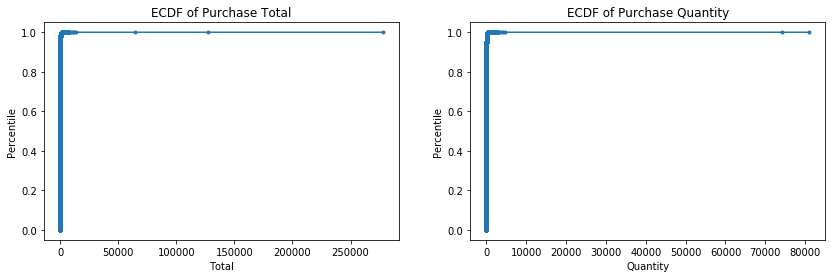

In [8]:
plt.figure(figsize = (14, 4))

# Total
plt.subplot(121)
x, y = ecdf(data.loc[data['total'] > 0, 'total'])
plt.plot(x, y, marker = '.')
plt.xlabel('Total'); plt.ylabel('Percentile'); plt.title('ECDF of Purchase Total');

# Quantity
plt.subplot(122)
x, y = ecdf(data.loc[data['total'] > 0, 'quantity'])
plt.plot(x, y, marker = '.')
plt.xlabel('Quantity'); plt.ylabel('Percentile'); plt.title('ECDF of Purchase Quantity');

# Prediction Problem

The goal of machine learning is to predict some quantity (regression) or a label (classification). Our data exploration showed that regression might not be the best approach because of the outliers, so we'll choose classification. We'll frame the problem as predicting whether or not a customer will spend more than \$500 in the next month. This could be useful to a business because it will let them market more effectively to those customers who are likely to spend more. Moreover, an online retailer could advertise differently to customers based on their predicted class of spending. 

Instead of picking just a single month for predictions, we can use each customer as a label multiple times. In other words, we not only predict whether a given customer will spend more than \$500 in May, but we also ask the same question in June, July, and so on. The thing to note is that for each month, we _can't use data from the future_ to predict the class of spending. Each month we can use information from _any previous month_ which means that our predictions should get more accurate as we advance further in time through the data since we'll be able to use more information. Each label for a customer therefore has a different set of features because there is more or less data available to us depending on the month. Doing this by hand is very tedious and error-prone, but we'll see how Featuretools is able to handle the times associated with each label to only generate legitimate features. 

## Making Labels

The function below takes in a start date and an end date (which we can set to 30 days apart) and generates a dataframe of the labels, which depends on how much the customer spent in the period. For customers who appear in the data prior to the start date but then do have a purchase in between the start and end date, we want to set their total to 0. If we simply did not include them in the labels, then that would be cheating since we have no way of knowing ahead of time that they will not spend anything in the next month.

In [9]:
def make_retail_cutoffs_total(start_date, end_date, threshold = 500):
    
    # Find customers who exist before start date
    customer_pool = data[data['order_date'] < start_date]['customer_id'].unique()
    tmp = pd.DataFrame({'customer_id': customer_pool})

    # For customers in the customer pool, find their sum between the start and end date
    totals = data[data['customer_id'].isin(customer_pool) & 
        (data['order_date'] > start_date) & 
        (data['order_date']<end_date)
    ].groupby('customer_id')['total'].sum().reset_index()
    
    # Merge with all the customer ids to record all customers who existed before start date
    totals = totals.merge(tmp, on = 'customer_id', how = 'right')

    # Set the total for any customer who did not have a purchase in the timeframe equal to 0
    totals['total'] = totals['total'].fillna(0)
    
    # Label is based on the threshold
    totals['label'] = (totals['total'] > threshold).astype(int)
        
    # The cutoff time is the start date
    totals['cutoff_time'] = pd.to_datetime(start_date)
    totals = totals[['customer_id', 'cutoff_time', 'total', 'label']]
    
    return totals

In [10]:
may_spending = make_retail_cutoffs_total(pd.datetime(2011, 5, 1), pd.datetime(2011, 6, 1))
may_spending.head()

,customer_id,cutoff_time,total,label
0,12372.0,2011-05-01,850.9050,1
1,12395.0,2011-05-01,547.4535,1
2,12399.0,2011-05-01,793.4850,1
3,12414.0,2011-05-01,273.6525,0
4,12415.0,2011-05-01,20940.4140,1


For each customer who appeared in the data before May, we have a label for them for the month of May. When we make features for these labels, we can only use data from _before May_. The `cutoff_time` represents the point at which any data we use must come before and the `label` is based on our threshold of \$500. 

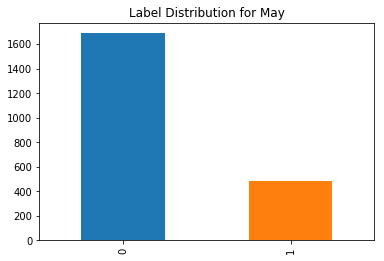

In [11]:
may_spending['label'].value_counts().plot.bar();
plt.title('Label Distribution for May');

This is an imbalanced classification problem which means that we probably don't want to use accuracy as our metric.

### Metrics

Instead of plain accuracy, we can measure performance in terms of:

* Precision: the percentage of customers predicted to spend more than \$500 that actually did
* Recall: the percentage of customers that actually spent more than \$500 that were correctly identified
* F1 score: the harmonic mean of precision and recall
* Receiver Operating Characterisic Area Under the Curve (ROC AUC): a 0 to 1 measure (with 1 being optimal) that measures the performance of a model across a range of thresholds

We'll have to establish a baseline for these metrics (which will be a little later) so we know whether machine learning is useful for this task.

Next we'll go ahead and make labels for the rest of the year. Keep in mind that this will generate one label for each customer for each month. We're used to thinking of a single label per customer, but since we have the data, we might as well use each customer as a training example as many times as possible (as long as we use valid data each time).

In [12]:
march_spending = make_retail_cutoffs_total('2011-03-01', '2011-04-01', 500)
april_spending = make_retail_cutoffs_total('2011-04-01', '2011-05-01', 500)
june_spending = make_retail_cutoffs_total('2011-06-01', '2011-07-01', 500)
july_spending = make_retail_cutoffs_total('2011-07-01', '2011-08-01', 500)
august_spending = make_retail_cutoffs_total('2011-08-01', '2011-09-01', 500)
september_spending = make_retail_cutoffs_total('2011-09-01', '2011-10-01', 500)
october_spending = make_retail_cutoffs_total('2011-10-01', '2011-11-01', 500)
november_spending = make_retail_cutoffs_total('2011-11-01', '2011-12-01', 500)
december_spending = make_retail_cutoffs_total('2011-12-01', '2012-01-01', 500)

In [13]:
labels = pd.concat([march_spending, april_spending, may_spending, june_spending, july_spending, august_spending, 
                    september_spending, october_spending, november_spending, december_spending], axis = 0)
labels.to_csv('../input/labels.csv')
labels.describe()

,customer_id,total,label
count,28133.000000,28133.000000,28133.000000
mean,15268.704155,326.503391,0.170547
std,1722.948845,1870.433936,0.376119
min,12346.000000,-5916.636000,0.000000
25%,13777.000000,0.000000,0.000000
50%,15235.000000,0.000000,0.000000
75%,16755.000000,196.020000,0.000000
max,18287.000000,115906.725000,1.000000


We have roughly 25,000 labels with ~17% of them positive. The total is very skewed, with several customers recording negative months (they had more cancellations than purchases). By framing this as a classification problem, we don't have to worry about the outlying purchase totals throwing off our model. 

Just to examine the data, we can plot the total spending distribution by month (with negative totals removed).

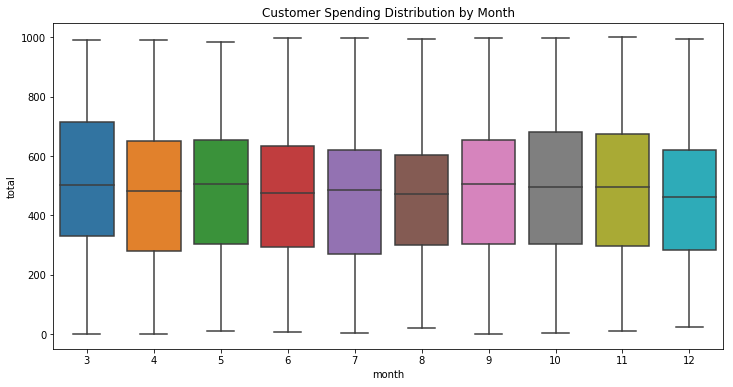

In [14]:
plot_labels = labels.copy()
plot_labels['month'] = plot_labels['cutoff_time'].dt.month

plt.figure(figsize = (12, 6))
sns.boxplot(x = 'month', y = 'total', 
            data = plot_labels[(plot_labels['total'] > 0) & (plot_labels['total'] < 1000)]);
plt.title('Customer Spending Distribution by Month');

Let's zoom in to one customer to make sure we understand the labels. 

In [15]:
labels.loc[labels['customer_id'] == 12347]

,customer_id,cutoff_time,total,label
845,12347.0,2011-03-01,0.0000,0
0,12347.0,2011-04-01,1049.8125,1
1111,12347.0,2011-05-01,0.0000,0
0,12347.0,2011-06-01,631.1580,1
1165,12347.0,2011-07-01,0.0000,0
0,12347.0,2011-08-01,965.1015,1
1357,12347.0,2011-09-01,0.0000,0
0,12347.0,2011-10-01,2135.6280,1
1658,12347.0,2011-11-01,0.0000,0
0,12347.0,2011-12-01,370.9530,0


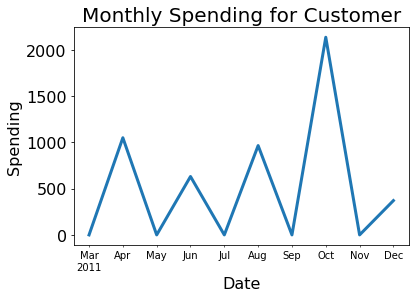

In [16]:
labels.loc[labels['customer_id'] == 12347].set_index('cutoff_time')['total'].plot(figsize = (6, 4), linewidth = 3)
plt.xlabel('Date', size = 16); 
plt.ylabel('Spending', size = 16); 
plt.title('Monthly Spending for Customer', size = 20);
plt.xticks(size = 16); plt.yticks(size = 16);

One customer, 8 different labels. It seems like it might be a little difficult to predict this customer's habits given her fluctuating total spending! We'll have to see if Featuretools is up to the task.

We now have our prediction problem all set. The next step is to start making features we can use in a machine learning model.

# Featuretools Implementation

The first step in Featuretools is to create an `EntitySet` which will hold all of our data and the relationships between the multiple tables (which we'll create shortly). Initially we'll add the entire `data` as an `entity` to the set. Since data has a `time_index`, we'll add that and specify the variable type of the product description.

In [17]:
es = ft.EntitySet(id="Online Retail Logs")

# Add the entire data table as an entity
es.entity_from_dataframe("purchases",
                         dataframe=data,
                         index="purchases_index",
                         time_index = 'order_date',
                         variable_types = {'description': ft.variable_types.Text})

es['purchases']

2018-08-01 10:31:15,101 featuretools.entityset - WARNING    index purchases_index not found in dataframe, creating new integer column


Entity: purchases
  Variables:
    purchases_index (dtype: index)
    order_id (dtype: categorical)
    product_id (dtype: categorical)
    quantity (dtype: numeric)
    order_date (dtype: datetime_time_index)
    price (dtype: numeric)
    customer_id (dtype: numeric)
    country (dtype: categorical)
    total (dtype: numeric)
    cancelled (dtype: boolean)
    description (dtype: text)
  Shape:
    (Rows: 375250, Columns: 11)

### Normalizing Entities

In order to create new tables out of the original table, we can normalize this `entity`. This creates new tables by creating a unique row for every variable that we pass in, such as the customer or the product.

The code below creates a new entity for the `products` where each row contains one product and the columns describe the product. 

In [18]:
# create a new "products" entity
es.normalize_entity(new_entity_id="products",
                    base_entity_id="purchases",
                    index="product_id",
                    additional_variables=["description"])

es['products'].df.head()

,product_id,description,first_purchases_time
20682,20682,RED RETROSPOT CHILDRENS UMBRELLA,2011-01-04 10:00:00
20718,20718,RED RETROSPOT SHOPPER BAG,2011-01-04 10:00:00
21498,21498,RED RETROSPOT WRAP,2011-01-04 10:00:00
21499,21499,BLUE POLKADOT WRAP,2011-01-04 10:00:00
22302,22302,COFFEE MUG PEARS DESIGN,2011-01-04 10:00:00


The `first_purchases_time` is automatically created because the `purchases` table has a time index. This represents the first time the product appears in the purchase data. We can use this table to create new features; the products table is a parent of the `purchases` table with the linking variable `product_id`. For each product in `products`, there can be multiple purchases of that product in `purchases`. 

We'll repeat the process to create tables for both the `customers` and the `orders`. Using `normalize_entity` automatically creates the relationships and time index so we don't have to do that ourselves. If we want to include any other additional variables in the table, we can pass those in. These variables must be unique to the object that we are normalizing for. As an example, each order comes from one country and one customer, so we can include those as additional variables when creating the `orders` table. However, the description is not unique to an order, so that should not be a variable that appears in the orders table.

In [19]:
es['purchases']

Entity: purchases
  Variables:
    purchases_index (dtype: index)
    order_id (dtype: categorical)
    product_id (dtype: id)
    quantity (dtype: numeric)
    order_date (dtype: datetime_time_index)
    price (dtype: numeric)
    customer_id (dtype: numeric)
    country (dtype: categorical)
    total (dtype: numeric)
    cancelled (dtype: boolean)
  Shape:
    (Rows: 375250, Columns: 10)

In [20]:
# create a new "customers" entity based on the orders entity
es.normalize_entity(new_entity_id="customers",
                    base_entity_id="purchases",
                    index="customer_id")

# create a new "orders" entity
es.normalize_entity(new_entity_id="orders",
                    base_entity_id="purchases",
                    index="order_id",
                    additional_variables=["country", 'cancelled'])

es

Entityset: Online Retail Logs
  Entities:
    purchases [Rows: 375250, Columns: 8]
    products [Rows: 3612, Columns: 3]
    customers [Rows: 4244, Columns: 2]
    orders [Rows: 20482, Columns: 4]
  Relationships:
    purchases.product_id -> products.product_id
    purchases.customer_id -> customers.customer_id
    purchases.order_id -> orders.order_id

# Deep Feature Synthesis 

Now that our `EntitySet` is defined with the proper relationships between tables, we can perform [deep feature synthesis](http://www.jmaxkanter.com/static/papers/DSAA_DSM_2015.pdf) to generate 100s or 1000s of features. We can theoretically make features for any entity, but since our objective is to classify customer spending, we'll make features for each customer for each month. 

The following call will generate features for each customer, resulting in a `feature_matrix` where each row consists of one customer for one month and each column is one feature. 

## Using cutoff times

To ensure the features are valid for the customer and the month, we'll pass in the labels dataframe that has the cutoff time for each customer for each month. Featuretools will make one row for each customer for each month, with the features for each month derived only from data prior to the cutoff time. This is an _extremely useful method_ because it means we don't have to worry about using illegal data to make features. For example, if we were doing this by hand, it would be very easy to create features that use information from the future to make features for months, which is not allowed (well there's nothing stopping us from doing this, but it will lead to very poor models in production). 

The requirements of the cutoff time dataframe are that the first column contains the ids corresponding to the index of the target entity, and the second column must have the cutoff times. Featuretools then takes care of the rest, for each month only using valid data. 

In [21]:
feature_matrix, feature_names = ft.dfs(entityset=es, target_entity='customers',
                                       cutoff_time = labels, verbose = 2,
                                       cutoff_time_in_index = True,
                                       chunk_size = len(labels), n_jobs = -1,
                                       max_depth = 1)

feature_matrix.head()

Built 27 features
EntitySet scattered to workers in 1.646 seconds
Elapsed: 01:23 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 1/1 chunks


,,SUM(purchases.quantity),SUM(purchases.price),SUM(purchases.total),STD(purchases.quantity),STD(purchases.price),STD(purchases.total),MAX(purchases.quantity),MAX(purchases.price),MAX(purchases.total),SKEW(purchases.quantity),...,NUM_UNIQUE(purchases.order_id),NUM_UNIQUE(purchases.product_id),MODE(purchases.order_id),MODE(purchases.product_id),DAY(first_purchases_time),YEAR(first_purchases_time),MONTH(first_purchases_time),WEEKDAY(first_purchases_time),total,label
customer_id,time,,,,,,,,,,,,,,,,,,,,,
12346.0,2011-03-01,0,3.4320,0.0000,74215.000000,0.000000,127352.940000,74215,1.7160,127352.9400,0.000000,...,2,1,541431,23166,18,2011,1,1,0.000,0
12347.0,2011-03-01,315,120.7305,784.3935,7.379955,3.945969,11.445900,24,21.0375,63.1125,0.864912,...,1,29,542237,20719,26,2011,1,2,0.000,0
12348.0,2011-03-01,601,69.3165,375.2760,62.344250,24.351888,12.961660,144,66.0000,68.9040,-0.742957,...,1,6,541998,21726,25,2011,1,1,0.000,0
12350.0,2011-03-01,197,107.7450,551.7600,4.215641,14.942464,11.646210,24,66.0000,66.0000,0.429792,...,1,17,543037,20615,2,2011,2,2,0.000,0
12352.0,2011-03-01,98,112.7775,489.2250,3.981066,5.355588,10.528141,12,21.0375,63.1125,0.548746,...,1,15,544156,21232,16,2011,2,2,502.722,1


We will want to drop the `total` and `label` columns before training because these were passed through from the `cutoff_time` data. (We clearly can't use these for modeling!) We also can remove the `MODE` of the order id and product id. These should not be used for creating features since they are index variables.

In [22]:
feature_matrix = feature_matrix.drop(columns = ['MODE(purchases.order_id)', 'MODE(purchases.product_id)'])
feature_matrix.shape

(28133, 27)

Initially we did not generate very many features because we limited the `max_depth` to 1. This means that only 1 aggregation will be stacked at a time. Let's take a look at some of the features. First, we'll zoom back in to a single one of the customers.

In [23]:
feature_matrix.loc[12347, :].sample(10, axis = 1)

,SUM(purchases.quantity),label,MONTH(first_purchases_time),MEAN(purchases.total),COUNT(purchases),SKEW(purchases.price),SKEW(purchases.quantity),MEAN(purchases.quantity),MEAN(purchases.price),STD(purchases.price)
time,,,,,,,,,,
2011-03-01,315,0,1,27.048052,29,2.588583,0.864912,10.862069,4.163121,3.945969
2011-04-01,315,1,1,27.048052,29,2.588583,0.864912,10.862069,4.163121,3.945969
2011-05-01,798,0,1,34.607660,53,2.600788,6.496496,15.056604,4.217151,4.049262
2011-06-01,798,1,1,34.607660,53,2.600788,6.496496,15.056604,4.217151,4.049262
2011-07-01,994,0,1,34.723437,71,2.409711,7.344654,14.000000,4.394113,3.926609
2011-08-01,994,1,1,34.723437,71,2.409711,7.344654,14.000000,4.394113,3.926609
2011-09-01,1271,0,1,36.886726,93,2.293921,8.044939,13.666667,4.565355,4.105807
2011-10-01,1271,1,1,36.886726,93,2.293921,8.044939,13.666667,4.565355,4.105807
2011-11-01,1947,0,1,39.757811,140,2.359314,8.985468,13.907143,4.455943,4.005108


If we want to predict spending in November, we can use any data from before November. As we get deeper into the year, we would expect our predictions to get more accurate because we are incorporating more information (we can see the count of purchases increasing as we use more data).

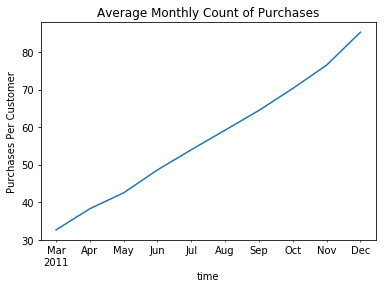

In [24]:
# feature_matrix.reset_index(inplace = True)

feature_matrix.groupby('time')['COUNT(purchases)'].mean().plot();
plt.title('Average Monthly Count of Purchases');
plt.ylabel('Purchases Per Customer');

This shows that as we progress through time, we have more purchases per customer to use for prediction.

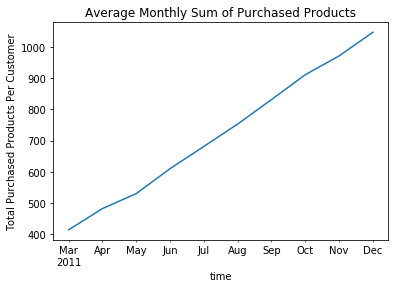

In [25]:
feature_matrix.groupby('time')['SUM(purchases.quantity)'].mean().plot();
plt.title('Average Monthly Sum of Purchased Products');
plt.ylabel('Total Purchased Products Per Customer');

Naturally, as we include more information, our forecasts should improve in accuracy. Therefore, if we are predicting purchase in November, we would expect better performance than predicting purchases in June.

## Correlations

As a first approximation of useful features, we can see if there are any significant correlations between the features and the `total`. We'll one-hot encode the categorical features first.

In [26]:
feature_matrix = pd.get_dummies(feature_matrix).reset_index()
feature_matrix.shape

(28133, 29)

In [27]:
corrs = feature_matrix.corr().sort_values('total')
corrs['total'].head()

MONTH(first_purchases_time)     -0.083372
DAY(first_purchases_time)       -0.050790
MIN(purchases.total)            -0.026663
WEEKDAY(first_purchases_time)   -0.009223
MIN(purchases.price)            -0.006407
Name: total, dtype: float64

In [28]:
corrs['total'].dropna().tail()

label                             0.343661
NUM_UNIQUE(purchases.order_id)    0.351811
SUM(purchases.quantity)           0.566804
SUM(purchases.total)              0.630549
total                             1.000000
Name: total, dtype: float64

A few of the features have a moderate positive correlation with the `total` (ignoring the `label` for now). The number and total of the purchases is clearly related to the total spending! 

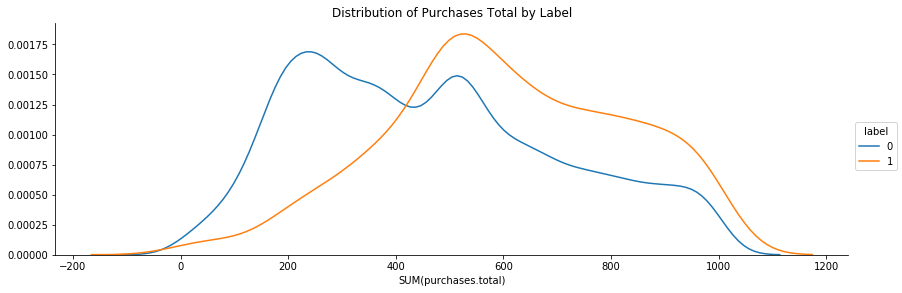

In [29]:
g = sns.FacetGrid(feature_matrix[(feature_matrix['SUM(purchases.total)'] > 0) & (feature_matrix['SUM(purchases.total)'] < 1000)],
                  hue = 'label', size = 4, aspect = 3)
g.map(sns.kdeplot, 'SUM(purchases.total)')
g.add_legend();
plt.title('Distribution of Purchases Total by Label');

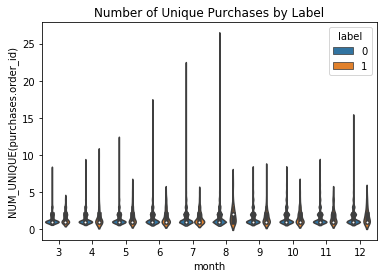

In [30]:
feature_matrix['month'] = feature_matrix['time'].dt.month
sns.violinplot(x = 'month', y = 'NUM_UNIQUE(purchases.order_id)', hue = 'label', figsize = (24, 6),
               data = feature_matrix[(feature_matrix['SUM(purchases.total)'] > 0) & (feature_matrix['SUM(purchases.total)'] < 1000)])
plt.title('Number of Unique Purchases by Label');

## Preliminary modeling

We can now directly use this feature matrix for training and making predictions with a machine learning model. We have a single table of data, so we'll want to split it into separate training and testing sets. For each month, we can do this by first subsetting the data and then using a random split into 30% testing and 70% training. If we want to make predictions for July, we'll subset the data to months before July, then split the data into the training and testing sets. 


### Model

For a model, we will use the `RandomForestClassifier` as implemented in Scikit-Learn. We'll keep most of the hyperparameters at the default values but increase the number of trees to 1000. This is not an optimized model but should allow us to tell whether or not our solution is better than a baseline estimate.

In [31]:
model = RandomForestClassifier(n_estimators = 1000, 
                               random_state = 50,
                               n_jobs = -1)

The function below trains and tests for a single month. We pass in the month, and the usable data is subsetted to before the month, and then split into 30% testing and 70% training. The model is trained and makes predictions (both the labels and the probabilities) which we can assess in terms of the metrics. 

In [32]:
def predict_month(month, feature_matrix, return_probs = False):
    
    
    feature_matrix['month'] = feature_matrix['time'].dt.month
    
    test_labels = feature_matrix.loc[feature_matrix['month'] == month, 'label']
    train_labels = feature_matrix.loc[feature_matrix['month'] < month, 'label']
    
    # Features
    X_train = feature_matrix[feature_matrix['time'].dt.month < month].drop(columns = ['customer_id', 'time',
                                                                                     'month', 'label', 'total'])
    X_test = feature_matrix[feature_matrix['time'].dt.month == month].drop(columns = ['customer_id', 'time',
                                                                                     'month', 'label', 'total'])
    feature_names = list(X_train.columns)
    
    pipeline = Pipeline([('imputer', Imputer(strategy = 'median')), 
                      ('scaler', MinMaxScaler())])

    # Fit and transform training data
    X_train = pipeline.fit_transform(X_train)
    X_test = pipeline.transform(X_test)
    
    # Labels
    y_train = np.array(train_labels).reshape((-1, ))
    y_test = np.array(test_labels).reshape((-1, ))
    
    print('Training on {} observations.'.format(len(X_train)))
    print('Testing on {} observations.\n'.format(len(X_test)))
    
    # Train 
    model.fit(X_train, y_train)
    
    # Make predictions
    predictions = model.predict(X_test)
    probs = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    p = precision_score(y_test, predictions)
    r = recall_score(y_test, predictions)
    f = f1_score(y_test, predictions)
    auc = roc_auc_score(y_test, probs)
    
    print(f'Precision: {round(p, 5)}')
    print(f'Recall: {round(r, 5)}')
    print(f'F1 Score: {round(f, 5)}')
    print(f'ROC AUC: {round(auc, 5)}')
    
    # Feature importances
    fi = pd.DataFrame({'feature': feature_names, 'importance': model.feature_importances_})
    
    if return_probs:
        return fi, probs
    
    return fi
    

In [33]:
june_fi = predict_month(6, feature_matrix)

Training on 5266 observations.
Testing on 2489 observations.

Precision: 0.55806
Recall: 0.4061
F1 Score: 0.47011
ROC AUC: 0.74927


We can plot the feature importances using a utility function. These should allow us to see what the model considers useful information for predicting spending.

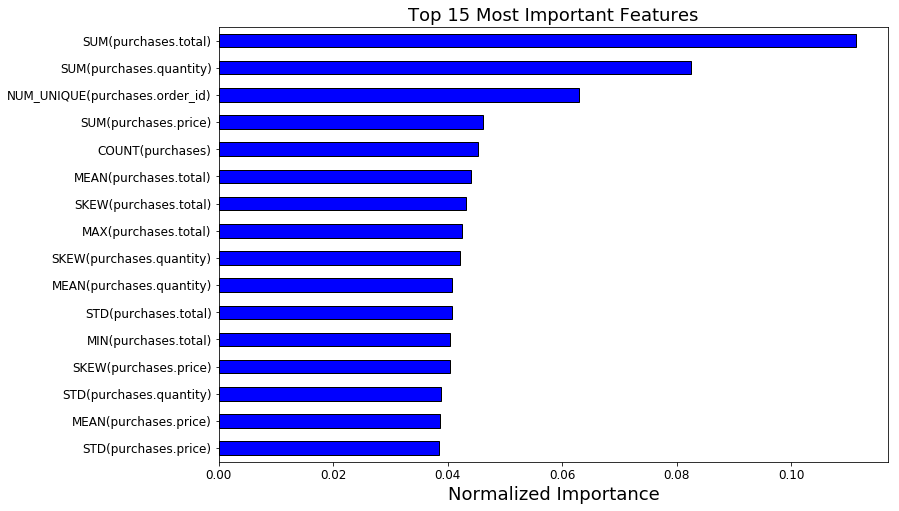

In [34]:
from utils import plot_feature_importances

norm_june_fi = plot_feature_importances(june_fi)

The most important features are those that are most correlated with the total. This should give us confidence that our machine learning model is learning the important relationships and that the Featuretools features are useful for the problem.

## Comparison to Baseline

One question we have to ask is how do those numbers compare to an informed baseline. If our model can't beat a simple baseline, then we might want to question our approach or even if machine learning is applicable to the problem. 

For an informed baseline, let's use the amount the customer spent in the past month to predict how much they will spend in the next month. We can try this for July 2011. For the probability (used for the ROC AUC), we'll divide the previous month's total by the threhold (so a spending of 0 corresponds to 0 probability) and then clip any values to 1.

In [35]:
labels['month'] = labels['cutoff_time'].dt.month
july_labels = labels[labels['month'] == 7]
june_labels = labels[labels['month'] == 6]

july_labels = july_labels.rename(columns = {'total': 'july_total'})
june_labels = june_labels.rename(columns = {'total': 'june_total'})

# Merge the current month with the previous
july_labels = july_labels.merge(june_labels[['customer_id', 'june_total']], on = 'customer_id', how = 'left')
july_labels['june_total'] = july_labels['june_total'].fillna(0)
july_labels['predicted_label'] = (july_labels['june_total'] > 500).astype(int)

july_labels['probability'] = july_labels['june_total'] / 500
    
# Set probabilities greater than 1 equal to 1
july_labels.loc[july_labels['probability'] > 1, 'probability'] = 1
    
july_labels.sample(10, random_state=50)

,customer_id,cutoff_time,july_total,label,month,june_total,predicted_label,probability
1647,17646.0,2011-07-01,0.0000,0,7,0.0000,0,0.000000
627,17068.0,2011-07-01,668.4975,1,7,516.0375,1,1.000000
2434,16446.0,2011-07-01,0.0000,0,7,0.0000,0,0.000000
2236,17158.0,2011-07-01,0.0000,0,7,0.0000,0,0.000000
1852,12902.0,2011-07-01,0.0000,0,7,0.0000,0,0.000000
1547,12945.0,2011-07-01,0.0000,0,7,0.0000,0,0.000000
241,14085.0,2011-07-01,474.9195,0,7,244.1175,0,0.488235
437,15624.0,2011-07-01,344.2395,0,7,0.0000,0,0.000000
2043,14546.0,2011-07-01,0.0000,0,7,0.0000,0,0.000000
1972,17398.0,2011-07-01,0.0000,0,7,0.0000,0,0.000000


To test whether this is reasonable, we can find the correlation between the previous months total and the current months total.

In [36]:
july_labels['july_total'].corr(july_labels['june_total'])

0.621279500664379

There is a moderate correlation between spending from one month to the next.

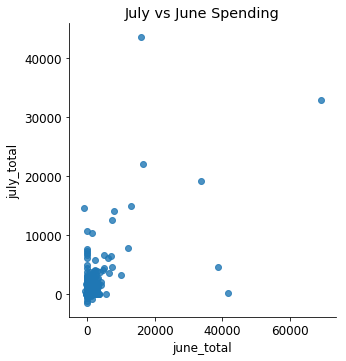

In [37]:
sns.lmplot('june_total', 'july_total', data = july_labels, fit_reg = False)
plt.title('July vs June Spending');

In [38]:
print('Precision: {:.5f}.'.format(precision_score(july_labels['label'], july_labels['predicted_label'])))
print('Recall: {:.5f}.'.format(recall_score(july_labels['label'], july_labels['predicted_label'])))
print('F1 Score: {:.5f}.'.format(f1_score(july_labels['label'], july_labels['predicted_label'])))
print('ROC AUC Score: {:.5f}.'.format(roc_auc_score(july_labels['label'], july_labels['probability'])))

Precision: 0.41784.
Recall: 0.39644.
F1 Score: 0.40686.
ROC AUC Score: 0.64365.


We can now compare this performance to that from the model. 

In [39]:
july_fi, july_probs = predict_month(7, feature_matrix, True)

Training on 7755 observations.
Testing on 2752 observations.

Precision: 0.53004
Recall: 0.33408
F1 Score: 0.40984
ROC AUC: 0.75527


For a classifier, the most important metric is the ROC AUC because that accounts for performance across all possible thresholds. We can adjust the threshold to maximize the Recall/Precision/F1 Score depending on our preferences.

To make sure that our model is really outperforming the baseline, we can plot the Receiver Operating Characteristic Curve for the two sets of predictions.

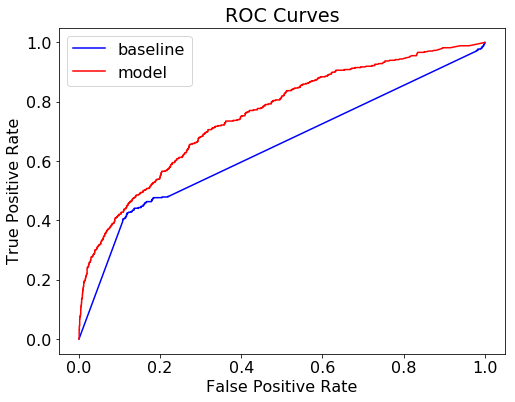

In [40]:
# Calculate false positive rates and true positive rates
base_fpr, base_tpr, _ = roc_curve(july_labels['label'], july_labels['probability'])
model_fpr, model_tpr, _ = roc_curve(feature_matrix[feature_matrix['month'] == 7]['label'], july_probs)

plt.figure(figsize = (8, 6))
plt.rcParams['font.size'] = 16
# Plot both curves
plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
plt.plot(model_fpr, model_tpr, 'r', label = 'model')
plt.legend();
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves');

Based on the metrics and this plot, we can say that our model does indeed outperform the informed baseline guess. Machine learning, and the features from Featuretools, yield us a better solution than using domain knowledge. 

__If we were an online retailer currently using an informed guess for advertising, machine learning could make our advertising campaigns more efficient.__

Let's take all of the code for comparing the baseline to the model and put it in a single function. First we need to calculate the informed baseline in a function. 

In [41]:
def informed_baseline(month_number, threshold = 500):
    """Calculate an informed baseline for a given month. 
    The informed baseline is guessing the previous month's spending
    for the next month. The probability is assessed by dividing
    the previous month's total by the threshold and setting
    any values greater than 1 to 1."""
    
    # Subset to the months
    month = labels[labels['month'] == month_number]
    previous_month = labels[labels['month'] == (month_number - 1)]
    
    previous_month = previous_month.rename(columns = {'total': 'previous_total'})

    # Merge the current month with the previous month
    month = month.merge(previous_month[['customer_id', 'previous_total']], on = 'customer_id', how = 'left')
    
    month['previous_total'] = month['previous_total'].fillna(0)
    month['probability'] = month['previous_total'] / threshold
    
    # Set probabilities greater than 1 equal to 1
    month.loc[month['probability'] > 1, 'probability'] = 1
    
    # Make the predicted label
    month['prediction'] = (month['previous_total'] > threshold).astype(int)
    
    print('Precision: {:.5f}.'.format(precision_score(month['label'], month['prediction'])))
    print('Recall: {:.5f}.'.format(recall_score(month['label'], month['prediction'])))
    print('F1 Score: {:.5f}.'.format(f1_score(month['label'], month['prediction'])))
    print('ROC AUC Score: {:.5f}.'.format(roc_auc_score(month['label'], month['probability'])))
    
    return month

In [42]:
def compare(month, feature_matrix):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    
    print('Baseline Performance')
    baseline = informed_baseline(month)
    
    print('\nModel Performance')
    fi, probs = predict_month(month, feature_matrix, return_probs=True)
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(baseline['label'], baseline['probability'])
    model_fpr, model_tpr, _ = roc_curve(feature_matrix[feature_matrix['month'] == month]['label'], probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves');
    

Baseline Performance
Precision: 0.41201.
Recall: 0.46714.
F1 Score: 0.43784.
ROC AUC Score: 0.67321.

Model Performance
Training on 5266 observations.
Testing on 2489 observations.

Precision: 0.55806
Recall: 0.4061
F1 Score: 0.47011
ROC AUC: 0.74927


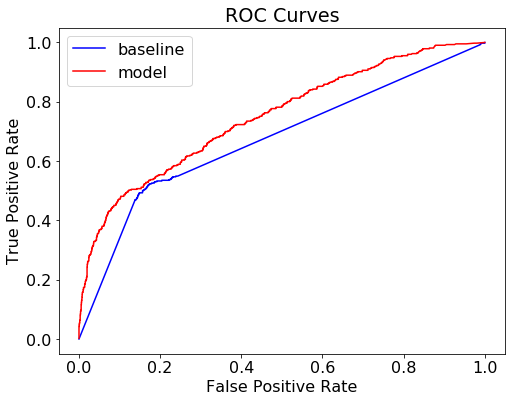

In [43]:
compare(6, feature_matrix)

Let's test December, when theoretically our model should do the best because it is training on the most data.

Baseline Performance
Precision: 0.21606.
Recall: 0.57547.
F1 Score: 0.31416.
ROC AUC Score: 0.69502.

Model Performance
Training on 23936 observations.
Testing on 4197 observations.

Precision: 0.31809
Recall: 0.48113
F1 Score: 0.38298
ROC AUC: 0.7924


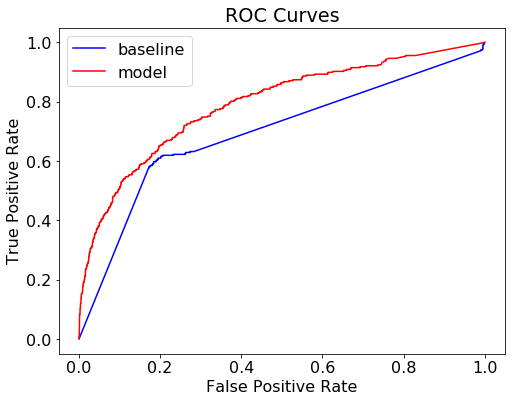

In [44]:
compare(12, feature_matrix)

We get a slightly better ROC AUC. It's possible that the data does not stay consistent over the couse of the year so using more data might not necessarily create a better model. In other words, consumer behavior can shift (due to seasonality) so the older data might not be relevant.

# Tuning Deep Feature Synthesis

We saw that even a basic implementation of Featuretools can yield a set of useful features. Next, we want to ask if we can achieve even better performance by generating a richer set of features. We can expand the capabilities of Featuretools by specifying the primitives we use, increasing the maximum depth of stacked features, writing our own custom primitives, identifying interesting values, and using seed features. For an explanation of all these concepts, refer to the [Featuretools documentation.](https://docs.featuretools.com/guides/tuning_dfs.html)

In the code cell below, we again use Featuretools but this time specify a few more primitives and increase the maximum depth. This might create some unnecessary features, but we can then use feature selection to remove them. Having too many features is a better problem than having too few! 

In [45]:
labels = labels.reset_index(drop = True)

In [46]:
feature_matrix, feature_names = ft.dfs(entityset=es, target_entity='customers',
                                       agg_primitives = ['std', 'max', 'min', 'mode',
                                                         'mean', 'skew', 'last', 'avg_time_between'],
                                       trans_primitives = ['cum_sum', 'cum_mean', 'day', 
                                                           'month', 'hour', 'weekend'],
                                       n_jobs = -1, chunk_size = 100, max_depth = 2,
                                       cutoff_time = labels, cutoff_time_in_index = True,
                                       verbose = 1)
feature_matrix.head()

Built 300 features
EntitySet scattered to workers in 6.335 seconds
Elapsed: 15:35 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 283/283 chunks


,,STD(purchases.quantity),STD(purchases.price),STD(purchases.total),MAX(purchases.quantity),MAX(purchases.price),MAX(purchases.total),MIN(purchases.quantity),MIN(purchases.price),MIN(purchases.total),MODE(purchases.order_id),...,CUM_MEAN(STD(purchases.total) by MODE(purchases.order_id)),CUM_MEAN(AVG_TIME_BETWEEN(purchases.order_date) by LAST(purchases.product_id)),CUM_MEAN(MIN(purchases.quantity) by MODE(purchases.order_id)),DAY(LAST(purchases.order_date)),MONTH(LAST(purchases.order_date)),HOUR(LAST(purchases.order_date)),WEEKEND(LAST(purchases.order_date)),total,label,month
customer_id,time,,,,,,,,,,,,,,,,,,,,,
12346.0,2011-03-01,74215.000000,0.000000,127352.940000,74215,1.7160,127352.9400,-74215,1.7160,-127352.940,541431,...,127352.940000,960.0,-74215.0,18,1,10,False,0.000,0,3
12347.0,2011-03-01,7.379955,3.945969,11.445900,24,21.0375,63.1125,3,0.6930,8.316,542237,...,11.445900,0.0,3.0,26,1,14,False,0.000,0,3
12348.0,2011-03-01,62.344250,24.351888,12.961660,144,66.0000,68.9040,1,0.4785,33.660,541998,...,12.961660,0.0,1.0,25,1,10,False,0.000,0,3
12350.0,2011-03-01,4.215641,14.942464,11.646210,24,66.0000,66.0000,1,1.4025,14.025,543037,...,11.646210,0.0,1.0,2,2,16,False,0.000,0,3
12352.0,2011-03-01,3.981066,5.355588,10.528141,12,21.0375,63.1125,3,1.4025,16.830,544156,...,10.528141,0.0,3.0,16,2,12,False,502.722,1,3


Before we can use these features for modeling, we need to one-hot encode them. Because some of the features are built from the id variables, one-hot encoding them will create far too many features. We'll have to be careful about increasing the number of columns too greatly. First let's look at the `object` type columns.

In [47]:
feature_matrix.loc[:, feature_matrix.dtypes == 'object'].columns

Index(['MODE(purchases.order_id)', 'MODE(purchases.product_id)',
       'LAST(purchases.order_id)', 'LAST(purchases.product_id)',
       'MODE(purchases.orders.country)', 'LAST(purchases.orders.country)'],
      dtype='object')

We'll remove the `order_id` and `product_id` derived columns. One-hot encoding the countries will not add too many columns since there are a limited number of countries. 

In [48]:
feature_matrix.drop(columns = ['MODE(purchases.order_id)', 'MODE(purchases.product_id)',
                               'LAST(purchases.order_id)', 'LAST(purchases.product_id)'], inplace = True)

In [49]:
feature_matrix = pd.get_dummies(feature_matrix).reset_index()
feature_matrix.shape

(28133, 371)

Now we can use these features to build a machine learning model and compare to the baseline.

In [50]:
labels = labels.sort_values(['cutoff_time', 'customer_id'])
feature_matrix['time'] = list(labels['cutoff_time'])

Baseline Performance
Precision: 0.21606.
Recall: 0.57547.
F1 Score: 0.31416.
ROC AUC Score: 0.69502.

Model Performance
Training on 23936 observations.
Testing on 4197 observations.

Precision: 0.39227
Recall: 0.66981
F1 Score: 0.49477
ROC AUC: 0.90709


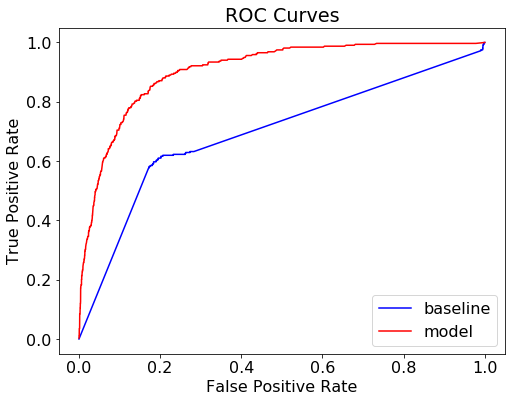

In [51]:
compare(12, feature_matrix)

The performance is slightly better than with the default primitives. Let's look at the most important features. 

Training on 23936 observations.
Testing on 4197 observations.

Precision: 0.39227
Recall: 0.66981
F1 Score: 0.49477
ROC AUC: 0.90709


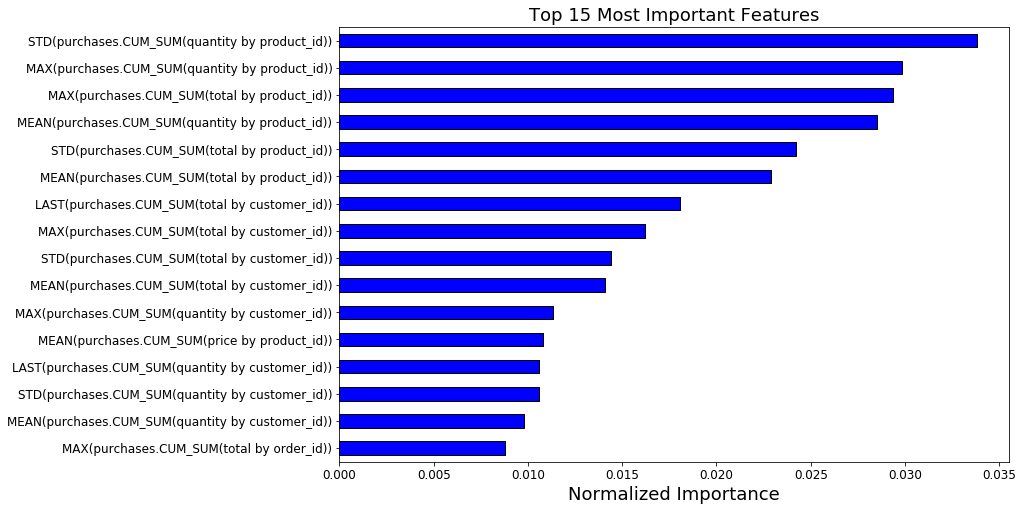

In [52]:
december_fi = predict_month(12, feature_matrix)
norm_fi = plot_feature_importances(december_fi)

The most important features all have to do with `cum_sum`. Intuitively, this makes sense: tracking the total amount that a customer has purchased thus far seems like an effective method for predicting how much they will spend in the next month.

## Feature Selection 

At this point, we might want to apply some feature selection to our `feature_matrix`. It's likely that many of the features are highly correlated which can have a negative impact on model performance. 

The following call removes:

* Any features with more than 80% missing values 
* Any features with only a single unique value
* One out of every pair of columns with a correlation greater than 0.9.

In [53]:
from utils import feature_selection

%load_ext autoreload
%autoreload 2

In [54]:
feature_matrix_selection = feature_selection(feature_matrix.drop(columns = ['time', 'customer_id']))

Original shape:  (28133, 369)
0 missing columns with threshold: 90.
0 zero variance columns.
238 collinear columns removed with threshold: 0.95.
Total columns removed:  238
Shape after feature selection: (28133, 131).


Training on 23936 observations.
Testing on 4197 observations.

Precision: 0.40693
Recall: 0.70126
F1 Score: 0.51501
ROC AUC: 0.90893


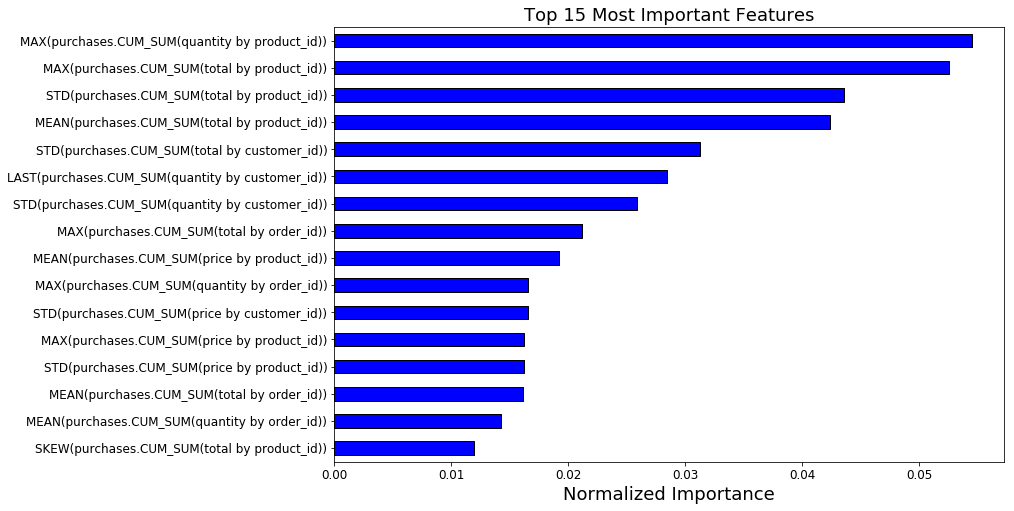

In [55]:
feature_matrix_selection['time'] = feature_matrix['time']
feature_matrix_selection['customer_id'] = feature_matrix['customer_id']

december_fi = predict_month(12, feature_matrix_selection)
norm_fi = plot_feature_importances(december_fi)

Feature selection did not significantly improve our model performance. 

## Custom Primitives

We saw that an informed baseline guess just using the previous month's total yielded a decent solution (although worse than machine learning). Therefore, we might want to consider using this as a feature in our model. To build this feature (which will actually find the total of any numeric column for the previous month) we can write a custom primitive. __Custom primitives__ allow us to expand on the capabilities of Featuretools by writing functions that use our domain knowledge. Featuretools will still stack custom primitives allowing us to effectively amplify any previous experience we have with the problem.

In [56]:
from featuretools.primitives import make_agg_primitive

This primitive will take in a `numeric` column, a `datetime`, and the `time` (representing `cutoff_time`) and return the sum of the `numeric` column for the month prior to the cutoff time. 

In [57]:
def total_previous_month(numeric, datetime, time):
    """Return total of `numeric` column in the month prior to `time`."""

    df = pd.DataFrame({'value': numeric, 'time': datetime})
    previous_month = time.month - 1
    df = df[df['time'].dt.month == previous_month]
    
    total = df['value'].sum()
    
    return total

We need to specify the input and output types of the primitive as well as that it `uses_calc_time` which means it needs to cutoff time. 

In [58]:
total_previous = make_agg_primitive(total_previous_month, input_types = [ft.variable_types.Numeric,
                                                                         ft.variable_types.Datetime],
                                    return_type = ft.variable_types.Numeric, 
                                    uses_calc_time = True)

Since we already have a decent set of features, we don't want to have to recalculate all of them. Therefore we'll just calculate the custom primitives and then join these to the existing feature matrix.

In [59]:
feature_matrix_custom, feature_names_custom = ft.dfs(entityset=es, target_entity='customers',
                                                     cutoff_time = labels, 
                                                     cutoff_time_in_index = True, 
                                                     agg_primitives = [total_previous], 
                                                     trans_primitives = [], chunk_size = len(labels),
                                                     verbose = 1, n_jobs = 4)

Built 3 features
EntitySet scattered to workers in 1.801 seconds
Elapsed: 02:18 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 1/1 chunks


In [60]:
feature_matrix_custom.drop(columns = ['total', 'label', 'month'], inplace = True)
feature_matrix_custom.reset_index(inplace = True)

In [61]:
feature_matrix_new_selection = feature_matrix_selection.merge(feature_matrix_custom, on = ['customer_id', 'time'], 
                                                          how = 'left')

Training on 23936 observations.
Testing on 4197 observations.

Precision: 0.40545
Recall: 0.70126
F1 Score: 0.51382
ROC AUC: 0.90866


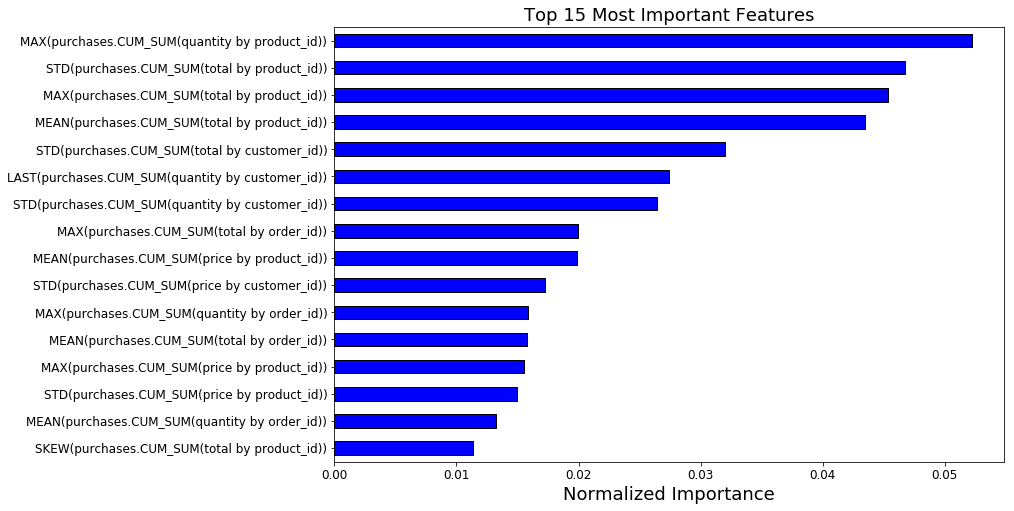

In [62]:
december_fi = predict_month(12, feature_matrix_new_selection)
norm_fi = plot_feature_importances(december_fi)

The `TOTAL_PREVIOUS_MONTH(purchases.total, order_date)` was one of the most important features and came from our custom primitive! Moreover, the final performance of the model was slightly better with the added custom primitive. Therefore, we can be pretty confident that using our domain knowledge in featuretools resulted in a better feature matrix. Using custom primitives is one of many ways that we can encode domain knowledge into a set of featuretools features and expand the capabilities of this library. 

We can do one final test on this set of features to make sure that it performs better than the baseline across all the months of the data.

Baseline Performance
Precision: 0.52465.
Recall: 0.30849.
F1 Score: 0.38853.
ROC AUC Score: 0.62495.

Model Performance
Training on 3094 observations.
Testing on 2172 observations.

Precision: 0.81224
Recall: 0.41201
F1 Score: 0.5467
ROC AUC: 0.85895


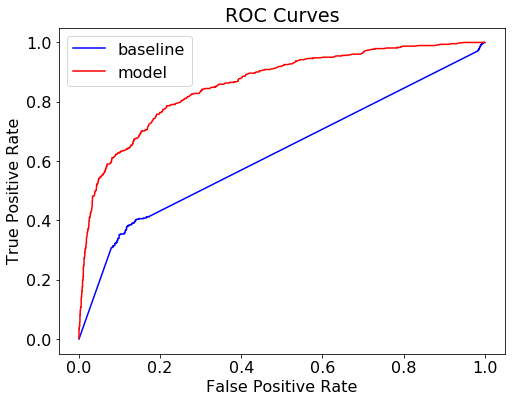

In [63]:
compare(5, feature_matrix_new_selection)

Baseline Performance
Precision: 0.40089.
Recall: 0.40179.
F1 Score: 0.40134.
ROC AUC Score: 0.66544.

Model Performance
Training on 10507 observations.
Testing on 2970 observations.

Precision: 0.67079
Recall: 0.60491
F1 Score: 0.63615
ROC AUC: 0.91278


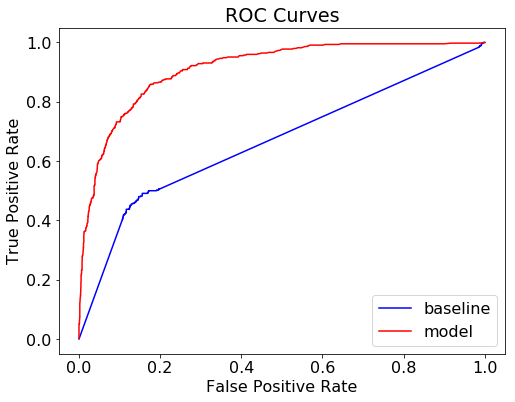

In [64]:
compare(8, feature_matrix_new_selection)

Feel free to check all of the months! It's clear that featuretools and machine learning is able to outperform the baseline for this problem. Even without concentrating on the model, we were able to perform significantly better than a well-informed guess. With some minor hyperparameter tuning (using random search) we could achieve even better performance. 

## Precision Recall Curve

Our model was using a default threshold of 0.5 to make predictions. We can use the precision recall curve to identify the ideal threshold for our model. For example, we may care more about identifying customers who will spend more than \$500 than about false positive so we choose a threshold that results in high recall but low precision. Conversely, we may want to limit false positives even if that means missing some potential high-spending customers so we would try for a higher level of precision. The ideal threshold for a classifier will depend on the problem. However, using the ROC AUC, we know that our model can outperform the baseline. 

In [65]:
def precision_recall(month, feature_matrix):
    "Show the precision vs recall curve for a month"
    
    # Find the probability
    fi, probs = predict_month(month, feature_matrix, 
                              return_probs = True)
    
    precision, recall, t = precision_recall_curve(labels.loc[labels['cutoff_time'].dt.month == month, 'label'], 
                                                  probs)
    
    plt.step(recall, precision, color='b', alpha=0.5,
             where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.5,
                     color='b')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title("Precision vs. Recall Curve"); plt.show();

Training on 23936 observations.
Testing on 4197 observations.

Precision: 0.40693
Recall: 0.70126
F1 Score: 0.51501
ROC AUC: 0.90893


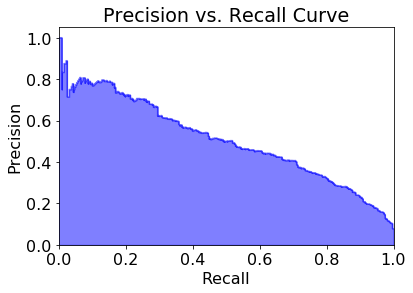

In [66]:
precision_recall(12, feature_matrix_selection)

Training on 16631 observations.
Testing on 3467 observations.

Precision: 0.66958
Recall: 0.48571
F1 Score: 0.56302
ROC AUC: 0.85795


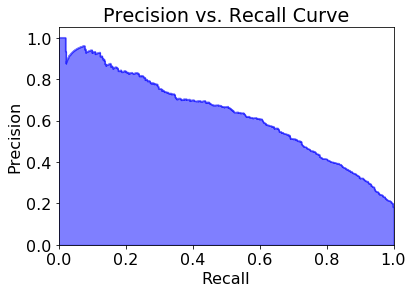

In [67]:
precision_recall(10, feature_matrix_selection)

Depending on what we want to maximize for, we can use these plots to select the appropriate threshold. If we want a recall around 80%, then we would have to accept a precision of near 40%. 

In [68]:
%%capture

# Record probabilities for each month
for month in range(4, 13):
    _, probs = predict_month(month, feature_matrix_new_selection, return_probs = True)
    
    temp_df = pd.DataFrame({'Automated': probs, 'month': month})
    
    if month == 4:
        probs_df = temp_df.copy()
    
    else:
        probs_df = probs_df.append(temp_df)


In [69]:
probs_df.head()

,Automated,month
0,0.162,4
1,0.026,4
2,0.114,4
3,0.112,4
4,0.325,4


In [70]:
probs_df['label'] = list(feature_matrix_new_selection[feature_matrix_new_selection['month'] > 3]['label'])

In [71]:
probs_df.to_csv('../input/auto_probs.csv')

# Conclusions

In this notebook we saw that Featuretools in a machine learning pipeline can result in better prediction of future customer behavior than an informed baseline guess. There are many advantages to using Featuretools in a time-series problem with multiple tables of data such as we often encouter in real life. Following are the key takeaways:

1. Featuretools takes care of the details for a time-series problem by ensuring that all of our features are made with valid data
    * Cutoff times for each label filter data 
2. Even using the default settings for Featuretools, we can create an effective machine learning model
    * The featuretools and random forest classifier outperformed an informed guess in terms of ROC AUC
3. We can build upon the capabilities of featuretools using custom primitives
    * There are other methods for improving featuretools we didn't even cover!
    * Changing the max depth and number of primitives can create more useful and interpretable features
4. Featuretools is an efficient method for creating valid data out of a set of time-series data tables

__When I tried manual feature engineering for this problem, I spend significantly more time than with Featuretools and yet was barely able to develop a model better than the baseline.__ Part of the issue was that I couldn't figure out how to use valid data and even when I could, managing the time aspect of the problem proved difficult leading to a poor model. Maybe this speaks to my limitations as a data scientist, but why not use a method such as featuretools if it exists and can make our job much simpler? Data science is about using the right methods to get the job done as efficiently as possible, and for the retail dataset, that method is featuretools plus machine learning. Presented below are the ROC AUC comparison between manual and automated feature engineering.

![](../images/results_comparison.png)